# Spectrogen

# To Do

### Old


1. ~~Make list~~
2. ~~[Get GPU working?](https://pytorch.org/docs/stable/notes/faq.html)~~
3. ~~Change model for generator Transposed convolution~~
4. Compress using discriminator
5. Debug training to find where memory goes WHOOOOOP


4. Fix Checkerboard Pattern
5. Train on single Genre
6. Upgrade our Discriminator (More CNN)
7. "Tunning" 

    a. Stride

    b. ~~CNN Nonsense~~
8. Run that shit all day
9. Train to generate specific Genere
10. Increase image resolution 

# Preperation

## Imports

In [2]:
import fastbook
from fastbook import *
#import torch
#print(torch.cuda.is_available())
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from PIL import Image
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
import random


c:\Users\zeusg\Envs\real-fast\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


## Variables

In [3]:
tired_bias = 0

batch_number = 10

epoch_number = 10

z_dim = 10

og_img_size =  [batch_number, z_dim , 8, 64]
dimensions = (batch_number, 1, 128, 1024)
noise_vec = [batch_number, z_dim]

first_layer = 16
second_layer = int(first_layer/2)
third_layer = int(second_layer/2)
fourth_layer = int(third_layer/2)

POOPs = 30
print_every = 1

device = "cuda"
#device = "cpu"

#torch.manual_seed(2.4)
#print(torch.cuda.initial_seed())

## Setup

In [4]:
#path = Path.BASE_PATH = r".\all_temp"
path = Path.BASE_PATH = r".\all"

music = DataBlock(blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items= get_image_files,
        splitter = RandomSplitter(seed = 23),
        get_y = using_attr(RegexLabeller(r'^([^.]+)'), 'name'))
dls = music.dataloaders(path, bs=batch_number)
#dls

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [5]:
music.summary(path)

Setting-up type transforms pipelines
Found 999 items
2 datasets of sizes 800,199
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      all\metal.00037.wav.png
    applying PILBase.create gives
      PILImageBW mode=L size=854x66
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      all\metal.00037.wav.png
    applying partial gives
      metal
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImageBW mode=L size=854x66, TensorCategory(6))


Found 999 items
2 datasets of sizes 800,199
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is ch

# Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, 3),
            nn.MaxPool2d(kernel_size=2),
            #nn.Conv2d(256, 512, 3),
            #nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(15360, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            #nn.LeakyReLU()
            #nn.Sigmoid()
        )
        
    def forward(self, image):
        return self.discriminator(image)

#discriminator = Discriminator().cuda()
#batch_x,y = dls.valid.one_batch()
#x, y = batch_x.cuda(), y.cuda()
#out = discriminator(batch_x)
#out

# Generator

### Utilities

In [7]:
class Reshape(nn.Module):
    """
    Class for performing a reshape as a layer in a sequential model.
    """
    def __init__(self, shape=[]):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)
    
    def extra_repr(self):
            # (Optional)Set the extra information about this module. You can test
            # it by printing an object of this class.
            return 'shape={}'.format(
                self.shape
            )

In [8]:
def view_gen_image(y):
    y = y.clone()
    image = y[0,0].detach().to("cpu").numpy() 
    plt.figure(figsize=(40,10))
    plt.imshow(image)
    #im = Image.fromarray(image).convert('RGB')
    #im.save("Generated.jpeg")

class PrintLayer(nn.Module):
    def __init__(self, label):
        super(PrintLayer, self).__init__()
        self.counter = 0 
        self.counter2 = 0
        self.label = label

    def forward(self, x):

        print(self.label)
        print(x.shape)
        view_gen_image(x)
        return x

In [9]:
def make_image(gen):
    x = torch.rand(noise_vec).to("cuda")
    y = gen(x)
    image = torch.reshape(y, dimensions)
    y = y.detach().to("cpu").numpy()
    y.ndim
    image = image[0,0].detach().to("cpu").numpy() 
    plt.figure(figsize=(40,10))
    plt.imshow(image)
    plt.show()
    #im = Image.fromarray(image).convert('RGB')
    #im.save("Generated.jpeg")
    #return image

### Old AreTwos

In [10]:
class AreTwoGenThree(nn.Module):
    #def __init__(self, z_dim=10, img_size=(64,16,213)):
    def __init__(self, z_dim=10, img_size=(64,31,255)):
        super(AreTwoGenThree, self).__init__()
        self.flat_img = int(np.prod(img_size))
        self.generator = nn.Sequential(
            # Fully connected layers
            nn.Linear(z_dim, 131072),
            Reshape((1, 128, 1024)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.generator(x)

In [11]:
#torch.manual_seed(56560)
class AreTwoGenTwo(nn.Module):
    #def __init__(self, z_dim=10, img_size=(64,16,213)):
    def __init__(self, z_dim=100, img_size=(64,31,255)):
        super(AreTwoGenTwo, self).__init__()
        self.flat_img = int(np.prod(img_size))
        self.generator = nn.Sequential(
            # Fully connected layers
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            #nn.ReLu(True),

            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, self.flat_img),
            #nn.ReLu(True),

            nn.LeakyReLU(0.2, inplace=True),
            Reshape(img_size),
            PrintLayer("Post Linear"),

            nn.ConvTranspose2d(64,32, (2,2), stride=2, padding=0, bias=False),
            PrintLayer("Conv2d 1"),

            nn.BatchNorm2d(32),
            PrintLayer("Batch Norm 1"),

            nn.LeakyReLU(0.2, inplace=True),
            PrintLayer("Relu1"),

            nn.ConvTranspose2d(32,1,(2,2), stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),
            PrintLayer("ConvTranspose2"),
            
            nn.Sigmoid(),
            PrintLayer("Sigmoid"),
        )

    def forward(self, x):
        return self.generator(x)


def test_gen():
    x = torch.rand(4, 100).cuda()
    gen = AreTwoGenTwo().cuda()
    y = gen(x)
    print(y.shape)
    view_gen_image(y)
#test_gen()

In [12]:
class AreTwoGenFour(nn.Module):
    def __init__(self):
        super(AreTwoGenFour, self).__init__()
        self.generator = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size=(3,3), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=10),
            nn.ReLU(True),
            #PrintLayer("1"),

            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size=(2,2), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=10),
            nn.ReLU(True),
            #PrintLayer("2"),

            nn.ConvTranspose2d(in_channels = 10, out_channels = 1, kernel_size=(2,2), stride=2, padding=2, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            #nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            #nn.BatchNorm2d(num_features=1),
            #nn.ReLU(True),
            #PrintLayer("3"),

            #nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=(2,2), stride=2, padding=1),
            #nn.BatchNorm2d(num_features=1),
            #nn.ReLU(True),
            #PrintLayer("4"),

            #nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=(2,2), stride=2, padding=1),
            #nn.BatchNorm2d(num_features=256),
            #nn.ReLU(True),
            #PrintLayer("5"),
            
            #nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=(2,2), stride=2, padding=1),
            #nn.BatchNorm2d(num_features=128),
            #nn.ReLU(True),
            #PrintLayer("6"),
            
        )
        self.output = nn.Tanh()

    def forward(self, x):
        x = self.generator(x)
        return self.output(x)
def test_gen():
    x = torch.rand(4, 10, 32, 256).cuda()
    #x = torch.rand(noise_vec).cuda()
    gen = AreTwoGenFour().cuda()
    y = gen(x)
    #print(y.shape)
    view_gen_image(y)
    return y

#y = test_gen()    
#y = y.clone()
#image = y[0,0].detach().to("cpu").numpy() 
#print(image.shape)
#plt.figure(figsize=(40,10))
#plt.imshow(image)
## 128 X 1024

### Current AreTwo

torch.Size([10, 10])
torch.Size([10, 1, 128, 1024])


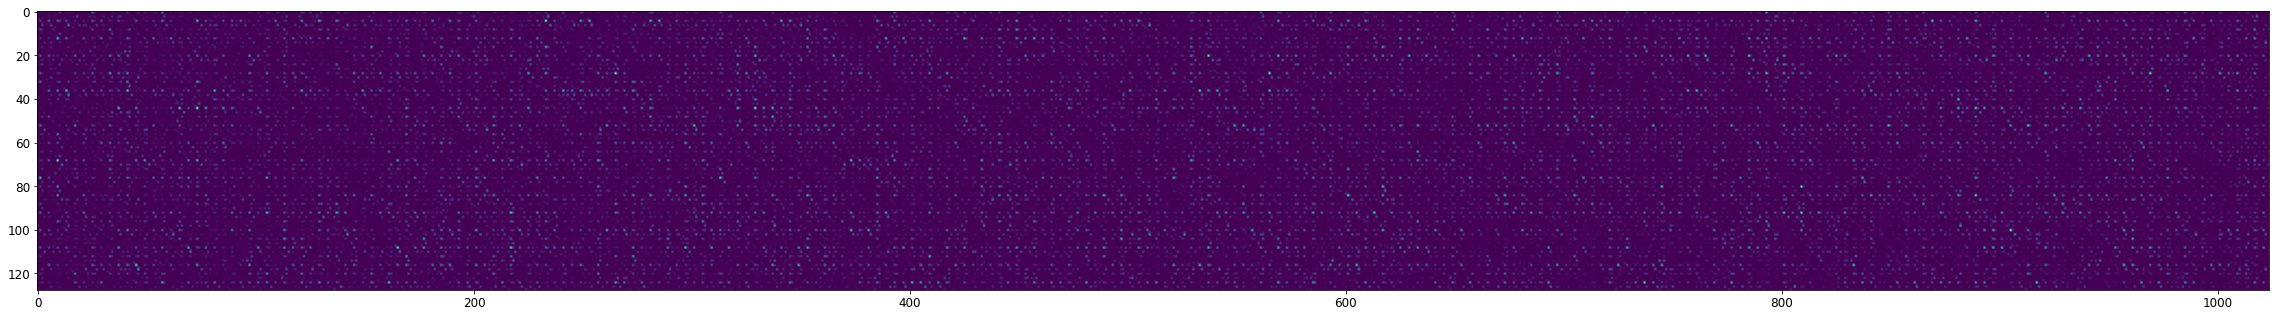

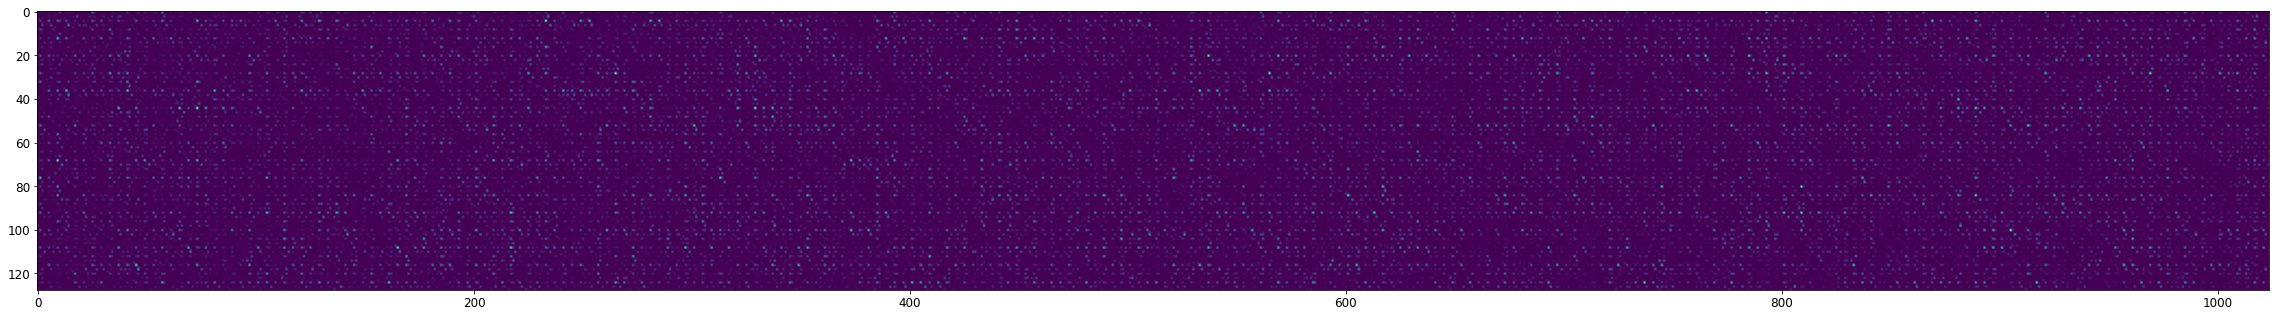

In [13]:
class AreTwoGenFour2(nn.Module):
    def __init__(self):
        super(AreTwoGenFour2, self).__init__()
        self.generator = nn.Sequential(
            
            nn.Linear(noise_vec[1], np.prod(og_img_size[1:])),
            nn.BatchNorm1d(np.prod(og_img_size[1:])),
            Reshape(og_img_size[1:]),

            nn.ConvTranspose2d(in_channels = og_img_size[1], out_channels = first_layer, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=first_layer),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = first_layer, out_channels = second_layer, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=second_layer),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = second_layer, out_channels = third_layer, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=third_layer),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = third_layer, out_channels = 2, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=2),
            nn.ReLU(True),

            #nn.ConvTranspose2d(in_channels = 2, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            #nn.BatchNorm2d(num_features=1),
            #nn.ReLU(True),

            nn.Conv2d(in_channels = 2,  out_channels = 1, kernel_size=1, stride=1, bias=False),
            #nn.BatchNorm2d(num_features=1),
            nn.ReLU(True),

            #nn.ConvTranspose2d(in_channels = 1, out_channels = 1, kernel_size=(2,2), stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(num_features=1),
            #nn.ReLU(True),

            #nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=(2,2), stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(num_features=256),
            #nn.ReLU(True),

            #nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=(2,2), stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(num_features=128),
            #nn.ReLU(True), 
        )
        self.output = nn.Tanh()

    def forward(self, x):
        x = self.generator(x)
        return self.output(x)

def test_gen():
    #x = torch.rand(4, 100, 32, 256).cuda()
    x = torch.rand(noise_vec).cuda()
    print(x.shape)
    gen = AreTwoGenFour2().cuda()
    y = gen(x)
    print(y.shape)
    view_gen_image(y)
    return y

y = test_gen()    
y = y.clone()
image = y[0,0].detach().to("cpu").numpy() 
#print(image.shape)

plt.figure(figsize=(40,10))
plt.imshow(image)

# Losses

### Discriminator Loss

In [14]:
def get_noise(num_images, z_dim, device="cuda"):
    noise = None
    if device == "cuda":
        noise = torch.rand(noise_vec , device=device).cuda()
    else:
        noise = torch.rand(noise_vec)
    return noise

In [15]:
def get_disc_loss(gen, disc, criterion, real_input, num_images, z_dim, device="cuda"):
    '''
    Return Loss of discriminator 
    Params: 
    Gen: Geneartor model
    Disc: Discrimiator Model
    criterion: Loss function
    Real Input: Our data set images
    Num_images: Len(real input)
    z_dim: Dimention of our noise vector
    Return a loss value for 1 batch
    '''
    
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, dimensions)
    fake_images.detach()
    fake_loss = criterion(disc(fake_images), torch.zeros((num_images,1),device=device))
    real_loss = criterion(disc(real_input), torch.ones((num_images,1),device=device))
    disc_loss = (fake_loss + real_loss)/2 + tired_bias
    return disc_loss

def test_disc():
    gen = AreTwoGenTwo().cuda()
    disc = Discriminator().cuda()
    criterion = nn.BCEWithLogitsLoss()
    x,y = dls.valid.one_batch()
    num_images = len(x)
    z_dim = 10
    loss = get_disc_loss(gen, disc, criterion, x, num_images, z_dim)
    return loss
    
#loss = test_disc()
#print(loss)

### Generator Loss

In [16]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device="cuda"):
    '''
    Returns the loss of the generator
    Params: 
    Gen: Generator Model
    Disc: Discrimiator Model
    Criterion: Loss Function
    num_images: The number of images the generator should produce
    z_dim: The dim of the noise vector
    Device: What device we run it on
    '''
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, dimensions)
    fake_images.detach()
    prediction = disc(fake_images)
    gen_loss = criterion(prediction, torch.ones(num_images,1, device=device))
    return gen_loss

def test_gen_loss():
    gen = Generator().cuda()
    disc = Discriminator().cuda()
    criterion = nn.BCEWithLogitsLoss()
    num_images = 4 
    z_dim = 10
    loss = get_gen_loss(gen, disc, criterion, num_images, z_dim)
    return loss

#loss = test_gen_loss()
#print(loss)
#loss = None

# Training

### Loss functions to test

In [17]:

# #criterion = nn.BCELoss
# what we've been using

#criterion = nn.BCEWithLogitsLoss()
# whub whub converges at 40

#criterion = nn.CrossEntropyLoss()
# doesn't work

#criterion = nn.L1Loss()
# chirpy and musical really quiet without the whub whub converges at 20

#criterion = nn.CTCLoss()
# TypeError: forward() missing 2 required positional arguments: 'input_lengths' and 'target_lengths'

#criterion = nn.NLLLoss()
# RuntimeError: 0D or 1D target tensor expected, multi-target not supported

#criterion = nn.PoissonNLLLoss()
# so bad, basically nothing

#criterion = nn.GaussianNLLLoss()
# TypeError: forward() missing 1 required positional argument: 'var'

#criterion = nn.KLDivLoss()
# UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.
# negative numbers lol
# demonic shit

#criterion = nn.MarginRankingLoss()
# vTypeError: forward() missing 1 required positional argument: 'target'

#criterion = nn.HingeEmbeddingLoss()
# waste of time

#criterion = nn.MultiLabelMarginLoss
# RuntimeError: Boolean value of Tensor with more than one value is ambiguous

#criterion = nn.HuberLoss()
# literally nothing

#criterion = nn.SmoothL1Loss()
# literally nothing

#criterion = nn.SoftMarginLoss()
# converges on the first epoch

#criterion = nn.MultiLabelSoftMarginLoss()
# okay 90s kids tv show computer

#criterion = nn.CosineEmbeddingLoss()
# TypeError: forward() missing 1 required positional argument: 'target'

#criterion = nn.MultiMarginLoss()
# RuntimeError: inconsistent target size, expected 4 but got [4, 1]

#criterion = nn.TripletMarginLoss()
# TypeError: forward() missing 1 required positional argument: 'negative'

# criterion = nn.TripletMarginWithDistanceLoss()
# TypeError: forward() missing 1 required positional argument: 'negative'

## Current training

In [18]:
criterion = nn.MSELoss()
# converges at 14 amazing whub but melodic A+

#gen = AreTwoGenFour().to(device)
#gen = AreTwoGenThree().to(device)
gen = AreTwoGenFour2().to(device)


gen_opt = torch.optim.Adam(gen.parameters())
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters())

cur_step = 0 
disc_loss_hist = [] 
gen_loss_hist = []
disc_loss_hist.append(25)
gen_loss_hist.append(25)

for epoch in range(epoch_number):
    disc_loss_batch = 0.0
    gen_loss_batch = 0.0
    
    for batch in dls.train:
        real_images, *_ = batch
        real_images = real_images.to(device)
        num_images = len(real_images)

        #Train discriminator
        if gen_loss_hist[-1] < POOPs:
            disc_opt.zero_grad()
            disc_loss = get_disc_loss(gen, disc, criterion, real_images, num_images, z_dim, device)
            disc_loss_batch+=disc_loss.item()
            disc_loss.backward(retain_graph=True)
            disc_opt.step()

        #Train Generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)
        gen_loss_batch+=gen_loss.item()
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

    print("Epoch: " + str(epoch + 1))
    print(disc_loss_batch/batch_number)
    print(gen_loss_batch/batch_number)

    disc_loss_hist.append(disc_loss_batch/batch_number)
    gen_loss_hist.append(gen_loss_batch/batch_number)

    if epoch % (print_every) == 0: 
        make_image(gen)
        for i in range(1):
            fake_images = gen(get_noise(num_images, z_dim, device=device))
            fake_images = torch.reshape(fake_images, dimensions)
            fake_images.detach()
            prediction = disc(fake_images)
            print(prediction)

RuntimeError: Calculated padded input size per channel: (2 x 51). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

### After training

In [ ]:
fig,ax = plt.subplots()
ax.plot(disc_loss_hist)

ax.set_xlim(0,40)
ax.set_ylim(0, 60)

ax.plot(gen_loss_hist)
fig.show()

In [ ]:
def make_image(gen):
    x = torch.rand(noise_vec).to("cuda")
    y = gen(x)

    image = torch.reshape(y, dimensions)

    y = y.detach().to("cpu").numpy()
    y.ndim

    image = image[0,0].detach().to("cpu").numpy()

    plt.figure(figsize=(40,10))
    plt.imshow(image)

    im = Image.fromarray(image).convert('RGB')
    im.save("Generated.jpeg")

    return image

def create_wav_file(image, file_name):
    S = librosa.feature.inverse.mel_to_stft(image, norm='slaney')
    y = librosa.griffinlim(S)
    
    sf.write(file_name, y, 22050)

image = make_image(gen)

In [ ]:
create_wav_file(image, "test.wav")

In [ ]:
y, sr = librosa.load(r"C:\Users\ldscho\spectro\ml_expore\test.wav", duration=23)
S = np.abs(librosa.stft(y))

S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

# Librosa

### new

### old 

In [ ]:
def generate_spectrogram(x, sr, save_name):
    #Creates the spectro gram
    spectro = librosa.sft(x)
    #Convert to decible 
    #Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(66,854))
    ax = fig.add_axes([0,0,1,1], frameon=False)
    ax.axis("off")
    librosa.display.specshow(spectro, sr=sr, cmap='grey', x_axis='time', y_axis ="hz")
    plt.savefig(save_name, quality=100, bbox_inches=0, pad_inches=0)
    librosa.cache.clear()
    return spectro

In [ ]:
#write("example2.wav", samplerate, lInverse.astype(np.int16))

In [ ]:
y, sr = librosa.load(r"C:\Users\ldscho\Downloads\pop.00001.wav")
M = librosa.feature.melspectrogram(y=y, sr=sr)

lM = M.astype(np.uint8)

im = Image.fromarray(lM)
im.save("lM.png")

image = Image.open(r"C:\Users\ldscho\spectro\ml_expore\lM.png")
data = np.asarray(image)

S = librosa.feature.inverse.mel_to_stft(data.astype(np.float64))
y = librosa.griffinlim(S)

sf.write("lM.wav", y, sr)

In [ ]:
plt.figure()
librosa.display.specshow(M)
plt.colorbar()

In [ ]:
def audio_to_spectrogram_and_back():
    x, sr = librosa.load(r"C:\Users\ldscho\Downloads\blues.00007.wav", duration=10)
    S = np.abs(librosa.stft(x))
    x_inv = librosa.griffinlim(S)
    sf.write("examplefinal.wav", x_inv, sr)
    return x_inv, S

In [ ]:
a, b = audio_to_spectrogram_and_back()

In [ ]:
def mel_generate(path):
    #[^\]*(?=[.][a-zA-Z]+$)
    pattern = re.compile(r'(.+)(\\)(?P<name>.+)(.wav)')
    for music_name in os.listdir(path):
        file_name = os.path.join(path, music_name)
        if os.path.isfile(file_name):
            match = list((re.finditer(pattern, file_name)))
            name = match[0].groupdict()['name']
            print(file_name)

            y, sr = librosa.load(file_name, duration=23.77)
            M = librosa.feature.melspectrogram(y=y, sr=sr)

            lM = M.astype(np.uint8)

            im = Image.fromarray(lM)
            im.save(name + ".png")

#mel_generate(r"C:\Users\ldscho\spectro\ml_expore\all")